In [1]:
%load_ext autoreload
%autoreload 2

# Load Dependencies
import matplotlib.pyplot as plt

import torch

import pyro
import numpy as np
import pyro.distributions as dist

from pyciemss.ODE.askem_primitives import sample, infer_parameters, intervene, optimization
from pyciemss.ODE.base import ODE, Time, State, Solution, Observation
from typing import Dict, Optional

from pyciemss.utils import get_tspan

# import warnings
# warnings.filterwarnings('ignore')

/Users/sam-basis/opt/anaconda3/envs/sw-demo-primitives/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Plotting Utilities

def setup_ax(ax=None):

    if not ax:
        fig = plt.figure(facecolor='w', figsize=(9, 9))
        ax = fig.add_subplot(111, axisbelow=True)

    ax.set_ylim(0, 1.1)
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Normalized Value')
    return ax

def plot_predictive(prediction, tspan, plot_var, plot_index=None, tmin=None, ax=None, alpha=0.2, color="black", **kwargs):


    if plot_index is not None:
        low = torch.quantile(prediction[plot_var][:, :, 0, plot_index], 0.05, dim=0).detach().numpy()
        up = torch.quantile(prediction[plot_var][:, :, 0, plot_index], 0.95, dim=0).detach().numpy()
    else:
        low = torch.quantile(prediction[plot_var], 0.05, dim=0).detach().numpy()
        up = torch.quantile(prediction[plot_var], 0.95, dim=0).detach().numpy()        

    if tmin:
        indeces = tspan >= tmin
    else:
        indeces = torch.ones_like(tspan).bool()

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    
    ax.fill_between(tspan[indeces], low[indeces], up[indeces], alpha=alpha, color=color, **kwargs)

    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)

    return ax

def plot_trajectory(data, tspan, plot_var, plot_index=None, ax=None, color='black', alpha=0.5, lw=0, marker='.', label=None):
    # Plot the data on three separate curves for S(t), I(t) and R(t)

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    if plot_index is not None:
        result = data[plot_var][:, :, 0, plot_index].squeeze().detach().numpy()
    else:
        result = data[plot_var].squeeze().detach().numpy()


    ax.plot(tspan, result, color, alpha=alpha, lw=lw, marker=marker, label=label)
    
    return ax

def plot_intervention_line(t, ax=None):
    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    ylim = ax.get_ylim()

    ax.vlines(t, min(ylim), max(ylim), color="grey", ls='-')

    return ax

# Construct a StratifiedSIR model

In [3]:
from pyro.nn import pyro_method

from pyciemss.ODE.base import ODE, Time, State, Solution, Observation
from pyciemss.utils import state_flux_constraint

class StratifiedSIR(ODE):
    def __init__(self,
                C_prior,
                Ro_prior,
                gamma_prior
                ):
        super().__init__()

        self.C_prior = C_prior
        self.Ro_prior = Ro_prior
        self.gamma_prior = gamma_prior

    @pyro_method
    def deriv(self, t: Time, state: State) -> State:

        S1, S2, S3, I1, I2, I3, R1, R2, R3 = state

        S1I1_contact = state_flux_constraint(S1, pyro.deterministic("S1I1_contact %f" % (t), self.Ro * self.C[0, 0] * S1 * I1))
        S1I2_contact = state_flux_constraint(S1, pyro.deterministic("S1I2_contact %f" % (t), self.Ro * self.C[0, 1] * S1 * I2))
        S1I3_contact = state_flux_constraint(S1, pyro.deterministic("S1I3_contact %f" % (t), self.Ro * self.C[0, 2] * S1 * I3))

        SI1_flux = state_flux_constraint(S1, S1I1_contact + S1I2_contact + S1I3_contact)

        S2I1_contact = state_flux_constraint(S2, pyro.deterministic("S2I1_contact %f" % (t), self.Ro * self.C[1, 0] * S2 * I1))
        S2I2_contact = state_flux_constraint(S2, pyro.deterministic("S2I2_contact %f" % (t), self.Ro * self.C[1, 1] * S2 * I2))
        S2I3_contact = state_flux_constraint(S2, pyro.deterministic("S2I3_contact %f" % (t), self.Ro * self.C[1, 2] * S2 * I3))

        SI2_flux = state_flux_constraint(S2, S2I1_contact + S2I2_contact + S2I3_contact)

        S3I1_contact = state_flux_constraint(S3, pyro.deterministic("S3I1_contact %f" % (t), self.Ro * self.C[2, 0] * S3 * I1))
        S3I2_contact = state_flux_constraint(S3, pyro.deterministic("S3I2_contact %f" % (t), self.Ro * self.C[2, 1] * S3 * I2))
        S3I3_contact = state_flux_constraint(S3, pyro.deterministic("S3I3_contact %f" % (t), self.Ro * self.C[2, 2] * S3 * I3))

        SI3_flux = state_flux_constraint(S3, S3I1_contact + S3I2_contact + S3I3_contact)

        # SI1_flux = SI2_flux = SI3_flux = 0.

        IR1_flux = state_flux_constraint(I1, pyro.deterministic("IR1_flux %f" % (t), self.gamma * I1))
        IR2_flux = state_flux_constraint(I2, pyro.deterministic("IR2_flux %f" % (t), self.gamma * I2))
        IR3_flux = state_flux_constraint(I3, pyro.deterministic("IR3_flux %f" % (t), self.gamma * I3))


        # Define ODE system
        dS1dt = -SI1_flux
        dS2dt = -SI2_flux
        dS3dt = -SI3_flux
        dI1dt = SI1_flux - IR1_flux
        dI2dt = SI2_flux - IR2_flux
        dI3dt = SI3_flux - IR3_flux
        dR1dt = IR1_flux
        dR2dt = IR2_flux
        dR3dt = IR3_flux

        return dS1dt, dS2dt, dS3dt, dI1dt, dI2dt, dI3dt, dR1dt, dR2dt, dR3dt

    @pyro_method
    def param_prior(self) -> None:
        self.C = pyro.sample("C_prior", self.C_prior)
        self.Ro = pyro.sample("Ro_prior", self.Ro_prior)
        self.gamma = pyro.sample("gamma", self.gamma_prior)

    @pyro_method
    def observation_model(self, solution: Solution, data: Optional[Dict[str, State]] = None) -> Solution:
        names = ["S1", "S2", "S3", "I1", "I2", "I3", "R1", "R2", "R3"]
        solution = tuple(torch.where(s > 0, s, 0) for s in solution)
        return [pyro.deterministic(names[i], solution[i]) for i in range(len(names))]
        # S1, S2, S3, I1, I2, I3, R1, R2, R3 = solution

        # # It's a little clunky that we have to do `None` handling for each implementation of 'observation_model'...
        # if data == None:
        #     data = {k: None for k in ["S_obs", "V_obs", "I_obs", "R_obs"]}

        # # TODO: Make sure observations are strictly greater than 0.

        # S_obs = pyro.sample("S_obs", dist.Normal(S, self.noise_var).to_event(1), obs=data["S_obs"])
        # V_obs = pyro.sample("V_obs", dist.Normal(V, self.noise_var).to_event(1), obs=data["V_obs"])
        # # We only observe the total number of infected people we don't know which of them are vaccinated.
        # I_obs = pyro.sample("I_obs", dist.Normal(I + Iv, self.noise_var).to_event(1), obs=data["I_obs"])
        # R_obs = pyro.sample("R_obs", dist.Normal(R, self.noise_var).to_event(1), obs=data["R_obs"])

        # return (S_obs, V_obs, I_obs, R_obs)

In [4]:
from pyro.nn import pyro_method

from pyciemss.ODE.base import ODE, Time, State, Solution, Observation
from pyciemss.utils import state_flux_constraint

class StratifiedSIR_M(ODE):
    def __init__(self,
                C_prior,
                Ro_prior,
                gamma_prior
                ):
        super().__init__()

        self.C_prior = C_prior
        self.Ro_prior = Ro_prior
        self.gamma_prior = gamma_prior

    @pyro_method
    def deriv(self, t: Time, state: State) -> State:
        S, I, R = state
        
        SI_flux = state_flux_constraint(S, pyro.deterministic("SI_flux %f" % (t), (torch.transpose(S, 0, 1) * I) * self.C * self.Ro).sum(axis=1))

        IR_flux = state_flux_constraint(I, pyro.deterministic("IR_flux %f" % (t), I * self.gamma))

        dSdt = -SI_flux
        dIdt = SI_flux - IR_flux
        dRdt = IR_flux

        return dSdt, dIdt, dRdt

    @pyro_method
    def param_prior(self) -> None:
        self.C = pyro.sample("C_prior", self.C_prior)
        self.Ro = pyro.sample("Ro_prior", self.Ro_prior)
        self.gamma = pyro.sample("gamma", self.gamma_prior)

    @pyro_method
    def observation_model(self, solution: Solution, data: Optional[Dict[str, State]] = None) -> Solution:
        # Flag this for Anirban later. Each observation function can define its own names internally and then
        # use them to construct traced sites.
        names = ["S", "I", "R"]

        solution = tuple(torch.where(s > 0, s, 0) for s in solution)
        return [pyro.deterministic(names[i], solution[i]) for i in range(len(names))]

In [68]:
import pyro.distributions as dist
import torch
import pyro

# Every time we see a question that says "assume the contact rate", we will simulate from that specific configuration of parameters
# and also a corresponding prior with "similar" assumptions. E.g. constant contact rate -> dirichlet prior with uniform weights.

C_prior = dist.Dirichlet(torch.tensor([[1000., 5., 1.], 
                                       [5., 1000., 5.], 
                                       [1., 5., 1000.]])).to_event(1)

Ro_mean   = torch.tensor(5.)
Ro_scale  = torch.tensor(0.5)

Ro_prior = dist.LogNormal(torch.log(Ro_mean), Ro_scale)

gamma_mean  = torch.tensor(1/14)
gamma_scale = torch.tensor(0.5)

gamma_prior = dist.LogNormal(torch.log(gamma_mean), gamma_scale)

ode_model = StratifiedSIR_M(C_prior, Ro_prior, gamma_prior)

In [69]:
# Define initial conditions
N = 6000
# initial_state = (torch.ones(1, 3) * 1999., torch.ones(1, 3), torch.zeros(1, 3))
initial_state = (torch.ones(1, 3) * 1999., torch.tensor([[1., 0., 0.]]), torch.zeros(1, 3))
initial_state = tuple(torch.as_tensor(s)/N for s in initial_state)
full_tspan = get_tspan(1, 25, 1000)

# Define simulation parameters
num_samples = 100

## Q: "What likely future outcomes does our model imply?"

In [70]:
prior_prediction = sample(ode_model, num_samples, initial_state, full_tspan)
single_prediction = sample(ode_model, 1, initial_state, full_tspan)

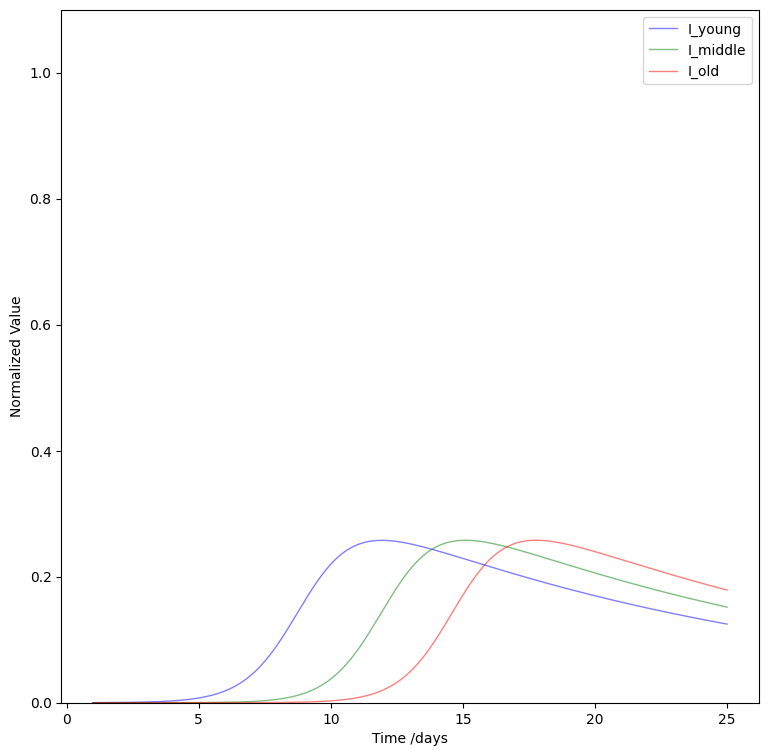

In [76]:

ax = setup_ax()

ax = plot_trajectory(single_prediction, full_tspan, plot_var="I", plot_index=0, ax=ax, color="blue", marker='', lw=1., label="I_young")
ax = plot_trajectory(single_prediction, full_tspan, plot_var="I", plot_index=1, ax=ax, color="green", marker='', lw=1., label="I_middle")
ax = plot_trajectory(single_prediction, full_tspan, plot_var="I", plot_index=2, ax=ax, color="red", marker='', lw=1., label="I_old")
ax.legend()

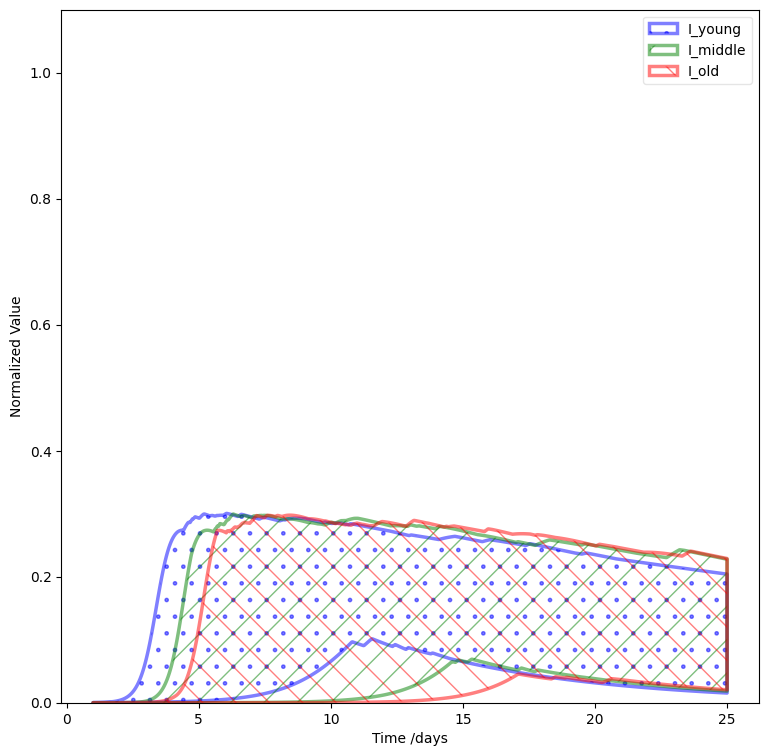

In [77]:
ax = setup_ax()

ax = plot_predictive(prior_prediction, full_tspan, plot_var="I", plot_index=0, ax=ax, label="I_young", hatch='.', edgecolor="blue", facecolor="none", linewidth=2.5, alpha=0.5)
ax = plot_predictive(prior_prediction, full_tspan, plot_var="I", plot_index=1, ax=ax, label="I_middle", hatch='/', edgecolor="green", facecolor="none", linewidth=2.5, alpha=0.5)
ax = plot_predictive(prior_prediction, full_tspan, plot_var="I", plot_index=2, ax=ax, label="I_old", hatch='\\', edgecolor="red", facecolor="none", linewidth=2.5, alpha=0.5)

# Probabilistic Forecasting - Exploring Possible Interventions


In [12]:

# from causal_pyro.query.do_messenger import do
from pyciemss.ODE.interventions import constant_intervention_builder, time_dependent_intervention_builder, state_dependent_intervention_builder, parameter_intervention_builder


## Q: "What would happen if we set the vaccination rate parameter, $\nu$?"


In [13]:
pyro.set_rng_seed(0)

rate_parameter_intervention = parameter_intervention_builder("nu", torch.tensor([0.01]))
# intervened_parameter_model = do(plotting_ode_model, rate_parameter_intervention)
plotting_intervened_parameter_model = intervene(plotting_ode_model, rate_parameter_intervention)
# intervened_parameter_prediction = Predictive(intervened_parameter_model, guide=guide, num_samples=num_samples)(final_observed_state, new_tspan)
intervened_parameter_prediction = sample(plotting_intervened_parameter_model, num_samples, final_observed_state, new_tspan, inferred_parameters=inferred_parameters)


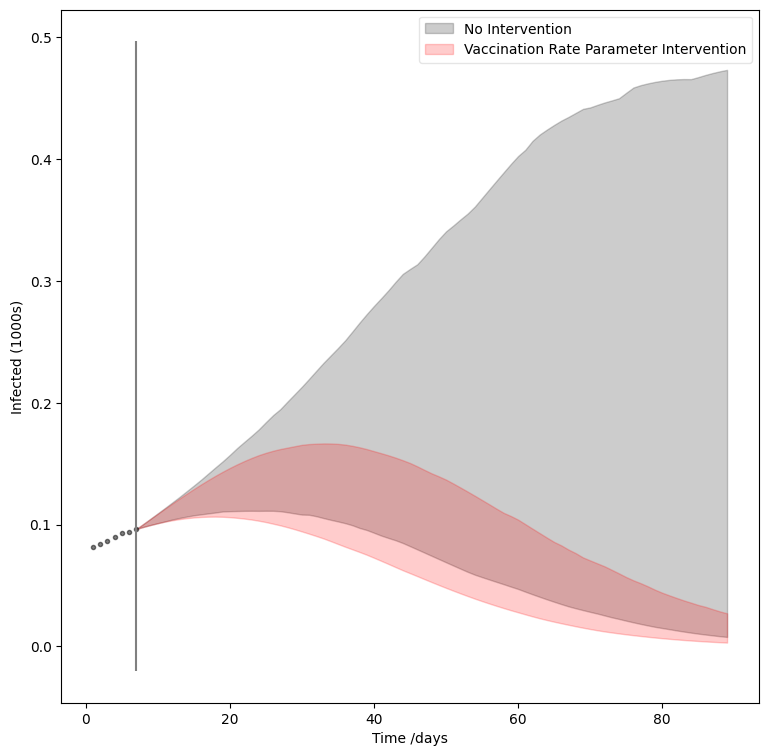

In [14]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, tmin=7, ax=ax, label="No Intervention")
ax = plot_predictive(intervened_parameter_prediction, new_tspan, ax=ax, color='red', label="Vaccination Rate Parameter Intervention")
ax = plot_intervention_line(7., ax=ax)

## Governor: "We can't change the rate parameter directly. Bring me another policy!"
## Q: "What would happen if we set the vaccination rate to a constant 500 people per day?"

In [28]:
pyro.set_rng_seed(0)

flux_intervention = constant_intervention_builder("SV_flux", torch.tensor([500.]), full_tspan)
# intervened_flux_model = do(ode_model, flux_intervention)
plotting_intervened_flux_model = intervene(plotting_ode_model, flux_intervention)
# intervened_flux_prediction = Predictive(plotting_intervened_flux, guide=guide, num_samples=num_samples)(final_observed_state, new_tspan)
rate_intervention_prediction = sample(plotting_intervened_flux_model, num_samples, final_observed_state, new_tspan, inferred_parameters=inferred_parameters)

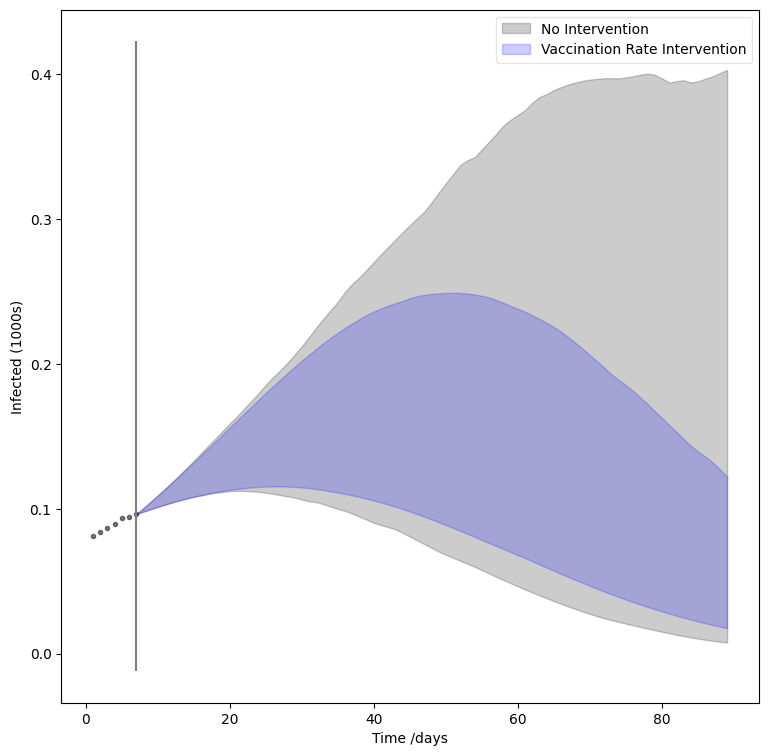

In [16]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, ax=ax, label="No Intervention")
ax = plot_predictive(rate_intervention_prediction, new_tspan, ax=ax, color='blue', label="Vaccination Rate Intervention")
ax = plot_intervention_line(7., ax=ax)

## Governor: "We have a lot more vaccines than that, but they aren't available yet!"
## Q: "What would happen if we set the vaccination rate to 500 people per day for the first month, then 750, then 1000?"


In [18]:
pyro.set_rng_seed(0)

def ramping_rate_up_intervention_function(t):
    month = torch.floor(t / 30.).int()
    return torch.tensor([500.0, 750.0, 1000.])[month]

ramping_rate_up_intervention = time_dependent_intervention_builder("SV_flux", ramping_rate_up_intervention_function, new_tspan)
# ramping_rate_up_intervention_model = do(plotting_ode_model, ramping_rate_up_intervention)
plotting_ramping_rate_up_intervention_model = intervene(plotting_ode_model, ramping_rate_up_intervention)
# ramping_rate_up_intervention_prediction = Predictive(plotting_ramping_rate_up_intervention_model, guide=guide, num_samples=num_samples)(final_observed_state, new_tspan)
ramping_intervention_prediction = sample(plotting_ramping_rate_up_intervention_model, num_samples, final_observed_state, new_tspan, inferred_parameters=inferred_parameters)


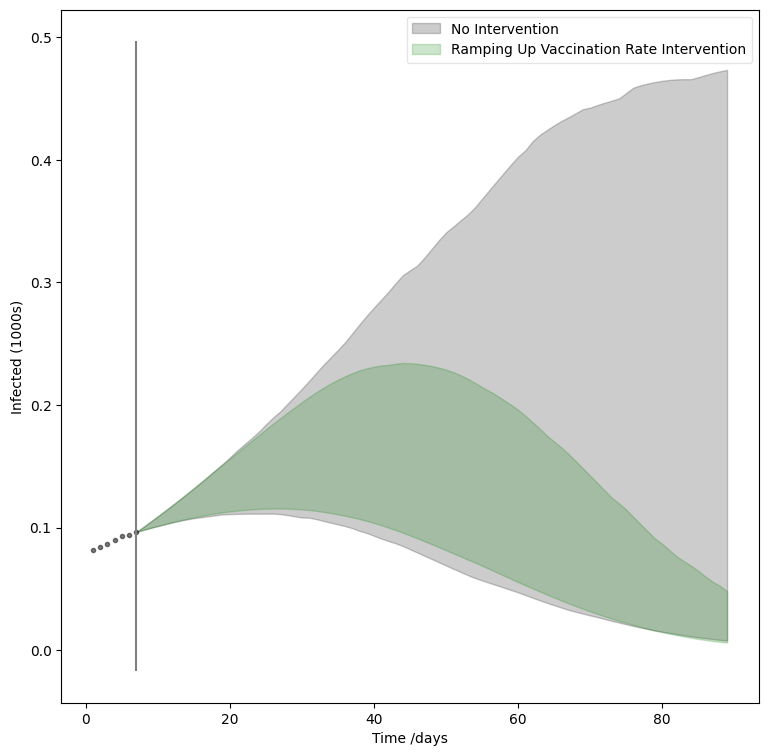

In [19]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, ax=ax, label="No Intervention")
ax = plot_predictive(ramping_intervention_prediction, new_tspan, ax=ax, color='green', label="Ramping Up Vaccination Rate Intervention")
ax = plot_intervention_line(7., ax=ax)


## Governor: "We can't force people to take a vaccine. Let's run a marketing campaign to encourage vaccination!"
## Q: "What would happen if the marketing campaign convinces 500 **more** people per day to get vaccinated than without it?"


In [22]:
pyro.set_rng_seed(0)

def vaccination_encouragement_intervention_function(SV_flux):
    return SV_flux + torch.tensor([500.])

vaccination_encouragement_intervention = state_dependent_intervention_builder("SV_flux", vaccination_encouragement_intervention_function, new_tspan)
# plotting_vaccination_encouragement_intervention_model = do(ode_model, vaccination_encouragement_intervention)
plotting_vaccination_encouragement_intervention_model = intervene(plotting_ode_model, vaccination_encouragement_intervention)
# vaccination_encouragement_intervention_prediction = Predictive(vaccination_encouragement_intervention_model, guide=guide, num_samples=num_samples)(final_observed_state, new_tspan)
vaccination_encouragement_intervention_prediction = sample(plotting_vaccination_encouragement_intervention_model, num_samples, final_observed_state, new_tspan, inferred_parameters=inferred_parameters)


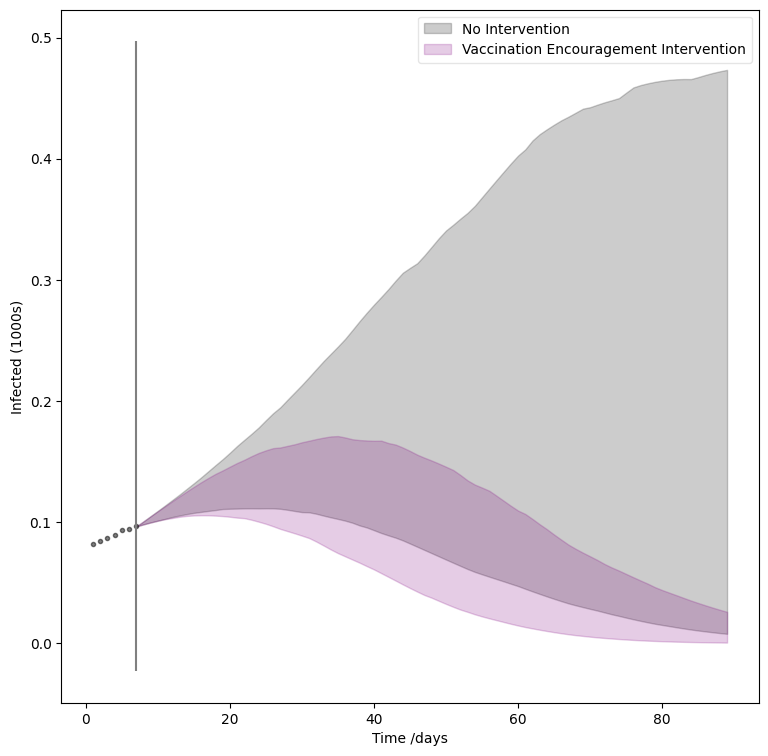

In [23]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, ax=ax, color='black', label="No Intervention")
ax = plot_predictive(vaccination_encouragement_intervention_prediction, new_tspan, ax=ax, color='purple', label="Vaccination Encouragement Intervention")
ax = plot_intervention_line(7., ax=ax)


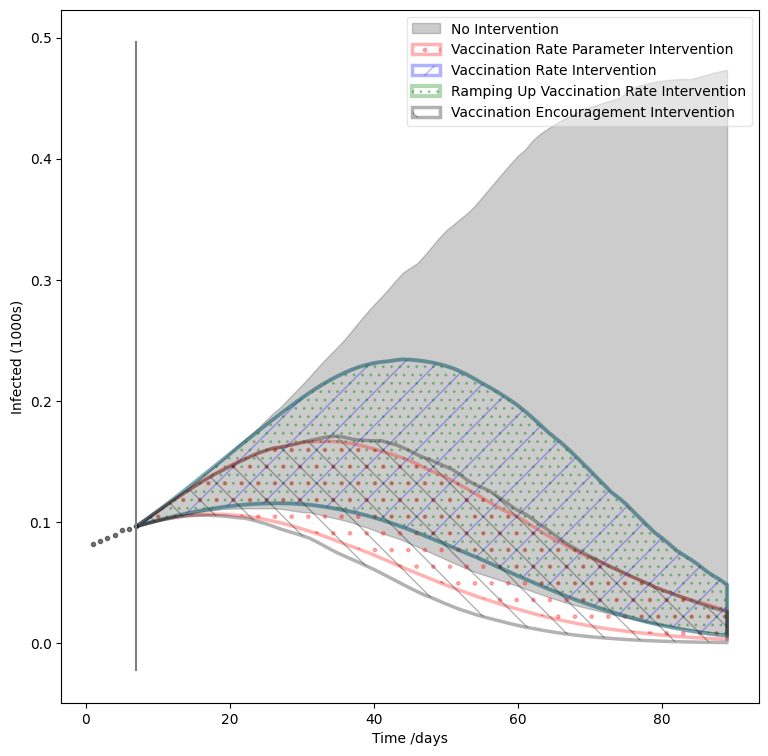

In [24]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, color='black', ax=ax, label="No Intervention")
ax = plot_predictive(intervened_parameter_prediction, new_tspan, hatch='.', edgecolor="red", linewidth=2.5, facecolor="none", ax=ax, alpha=0.3, label="Vaccination Rate Parameter Intervention")
ax = plot_predictive(rate_intervention_prediction, new_tspan, hatch='/', ax=ax, alpha=0.3, linewidth=2.5, edgecolor='blue', facecolor="none", label="Vaccination Rate Intervention")
ax = plot_predictive(ramping_intervention_prediction, new_tspan, hatch='..', linewidth=3, ax=ax, alpha=0.3, edgecolor='green', facecolor="none", label="Ramping Up Vaccination Rate Intervention")
ax = plot_predictive(vaccination_encouragement_intervention_prediction, new_tspan, hatch="\\", linewidth=2.5, ax=ax, alpha=0.3, edgecolor='black', facecolor="none", label="Vaccination Encouragement Intervention")
ax = plot_intervention_line(7., ax=ax)


## Governor: "Let's only market to young people!"
## Q: "What would happen if the marketing campaign convinces 500 more people age 18-24 per day to get vaccinated than without it?"


In [25]:

pyro.set_rng_seed(0)

stratified_intervention = state_dependent_intervention_builder("SV_flux_18-24", vaccination_encouragement_intervention_function, new_tspan)
# stratified_intervention_model = do(ode_model, stratified_intervention)
stratified_intervention_model = intervene(ode_model, stratified_intervention)


In [24]:

import sys
ipython = get_ipython()

def hide_traceback(exc_tuple=None, filename=None, tb_offset=None,
                   exception_only=False, running_compiled_code=False):
    etype, value, tb = sys.exc_info()
    value.__cause__ = None  # suppress chained exceptions
    return ipython._showtraceback(etype, value, ipython.InteractiveTB.get_exception_only(etype, value))

ipython.showtraceback = hide_traceback

raise ValueError("The Intervention Variable SV_flux_18-24 is not defined and can not be intervened on. To fix this error, revise the model to include SV_flux_18-24").with_traceback(None) from None

ValueError: The Intervention Variable SV_flux_18-24 is not defined and can not be intervened on. To fix this error, revise the model to include SV_flux_18-24

# Risk-based optimization under uncertainty
## Q: "What is the minimal vaccination policy that results in less than 150 infected individuals after 90 days?"

### Problem Formulation
* **Quantity of interest**: 7-day average of total infections after 90 days
    $$M(\mathbf{u}, \theta) = \frac{1}{7}\sum_{i=0}^6 I(t=90-i;\mathbf{u},\theta)+I_\text{V}(t=90-i;\mathbf{u},\theta)$$

* **Control**: $\mathbf{u}\in \mathcal{U} \subseteq \mathbb{R}^{n_u}$
    * Vaccination rate parameter: $u=\nu$
    * Scheduled intervention changing SV_flux over each month: $\mathbf{u} \in \mathbb{R}^3$
    * Other practical policies as interventions



* **Risk-based optimization under uncertainty problem formulation**
    * Objective Function - Minimize the vaccination rate.
    * Constraint - Risk of infections exceeding the prescribed threshold of 10, $\mathcal{R}( M(\mathbf{u}, \theta))$, is below the acceptable risk threshold, $\mathcal{R}_\text{threshold}$.

\begin{equation} 
\begin{split} 
\mathbf{u}^*= \underset{\mathbf{u}\in\mathcal{U}}{\arg\min}\ & \lVert \mathbf{u} \rVert_1 \\ \text{s.t.}\ & \mathcal{R}( M(\mathbf{u}, \theta)) \le \mathcal{R}_\text{threshold} 
\end{split} 
\end{equation}

## Comparing risk measures

![table_risk.png](figures/table_risk.png)

#### Adavantages of using alpha-superquantile
* Considers magnitude of infections exceeding the threshold:
    * Overcome limitations of hard thresholding
    * Desirable data-informed conservativeness
* Preserves properties of underlying quantities of interest, such as convexity

In [25]:
import os
import time
import pickle

import sys
sys.path.append("../")

import numpy as np
from scipy import stats
from matplotlib import ticker

from pyciemss.ODE.models import SVIIvR
from pyciemss.ODE.interventions import constant_intervention_builder

from pyciemss.risk.risk_measures import alpha_quantile, alpha_superquantile
from pyciemss.risk.ouu import computeRisk
from pyciemss.risk.qoi import nday_rolling_average

# Plotting helpers
def sideaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return

def sideaxishist(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # For y-axis
    ax.yaxis.set_major_locator(ticker.NullLocator())
    ax.tick_params(axis='x', labelsize=12)  # change fontsize for x-axis tick labels
    # ax.xaxis.major.formatter._useMathText = True
    return


co = ['#377eb8', '#ff7f00', '#984ea3', '#ffd92f', '#a65628']
rlabel = ['Q_alpha-based OUU', 'barQ_alpha-based OUU']

## Exploring the difference between Quantiles and Super-Quantiles

In [26]:
torch.manual_seed(1)

POLICY = np.array([100.])
N_SAMPLES = 1000

RISK = computeRisk(model=ode_model,
                 intervention_fun=lambda x: constant_intervention_builder("SV_flux", torch.from_numpy(x), new_tspan),
                 qoi=lambda y: nday_rolling_average(y, contexts=["I_obs"]),
                 risk_measure=alpha_superquantile,
                 num_samples=N_SAMPLES,
                 model_state=final_observed_state,
                 tspan=new_tspan,
                 guide=guide
                )

start_time = time.time()
sq_dataCube = RISK.propagate_uncertainty(POLICY)
end_time = time.time()
forward_time = end_time - start_time
time_per_eval = forward_time / N_SAMPLES
print(f"Forward UQ took {forward_time:.2f} seconds total ({forward_time/N_SAMPLES:.2e} seconds per model evaluation).")
sq_qoi = RISK.qoi(sq_dataCube)
sq_sv = RISK.risk_measure(sq_qoi)

RISK.risk_measure = alpha_quantile
q_sv = RISK(POLICY)

Forward UQ took 40.57 seconds total (4.06e-02 seconds per model evaluation).


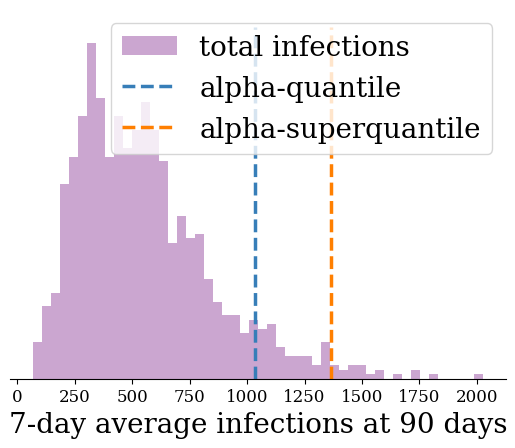

In [27]:
bins_hist = 50
fig1 = plt.figure()
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=18.)
cax = plt.gca()
sideaxishist(cax)
cax.hist(sq_qoi, color=co[2], bins=bins_hist, histtype='stepfilled', alpha=0.5, label='total infections')
miny = min(cax.get_ylim())
maxy = max(cax.get_ylim())
cax.vlines(q_sv, miny, maxy, linestyle='--', linewidth=2.5, label='alpha-quantile', color=co[0])
cax.vlines(sq_sv, miny, maxy, linestyle='--', linewidth=2.5, label='alpha-superquantile', color=co[1])
cax.set_xlabel('7-day average infections at 90 days', size=20)
cax.legend(loc='upper right', prop={'size': 20})
plt.show()

## Risk-based optimization under uncertainty with intervention on vaccination rate parameter $\nu$
**NOTE:** This is a demonstration of the interface, optimization is not run to convergence nor are enough samples generated to accurately estimate the risk, so take the results with a grain of salt.

In [28]:
from pyciemss.risk.ouu import RandomDisplacementBounds, computeRisk, solveOUU
from pyciemss.risk.qoi import nday_rolling_average
from pyciemss.risk.risk_measures import alpha_superquantile, alpha_quantile
import scipy

# Define problem specifics.
RISK_BOUND = 250.
X_MIN = 0.
X_MAX = 0.95

N_SAMPLES = int(5e2)
MAXITER = 10
TOL = 1e-5

RISK_ALPHA = 0.9

# Control action / intervention.
INIT_ITERATE = 0.75
INTERVENTION = lambda x: constant_intervention_builder("nu", x, new_tspan)

# Objective function.
OBJFUN = lambda x: x  # minimize the scalar value itself.

# Define the risk measure.
VAX_RISK = computeRisk(
                        model=noisy_ode_model,
                        intervention_fun=INTERVENTION,
                        qoi=lambda y: nday_rolling_average(y, contexts=["I_obs"]),
                        model_state=final_observed_state,
                        tspan=new_tspan,
                        risk_measure=lambda z: alpha_superquantile(z, alpha=RISK_ALPHA),
                        num_samples=N_SAMPLES,
                        guide=guide,
                        )

# Define problem constraints.
CONSTRAINTS = (
                # risk constraint
                {'type': 'ineq', 'fun': lambda x: RISK_BOUND - VAX_RISK(x)},

                # bounds on control
                # NOTE: perhaps use scipy.optimize.LinearConstraint in the future
                {'type': 'ineq', 'fun': lambda x: x - X_MIN},
                {'type': 'ineq', 'fun': lambda x: X_MAX - x}
               )

In [29]:
# Go do the dang thing.
print("Performing risk-based optimization under uncertainty ...")
print(f"Estimated wait time {time_per_eval*N_SAMPLES*MAXITER:.0f} seconds.")
sq_result = solveOUU(
                     x0=INIT_ITERATE,
                     objfun=OBJFUN,
                     constraints=CONSTRAINTS,
                     optimizer_algorithm="COBYLA",
                     tol=TOL,
                     options={
                         "disp": False,
                         "maxiter": MAXITER
                             },
                    ).solve()
print(f"Optimizer finished. Optimal Vaccination rate is:\t{sq_result.x[0]:.4}")
est_risk = VAX_RISK(sq_result.x[0])
print(f"Estimated risk was:\t{est_risk:.2f}")

Performing risk-based optimization under uncertainty ...
Estimated wait time 203 seconds.
Optimizer finished. Optimal Vaccination rate is:	1.75
Estimated risk was:	496.06


## Assess the effect of the control policy.

In [30]:
intervened_prediction = VAX_RISK.propagate_uncertainty(POLICY)
qois = VAX_RISK.qoi(intervened_prediction)

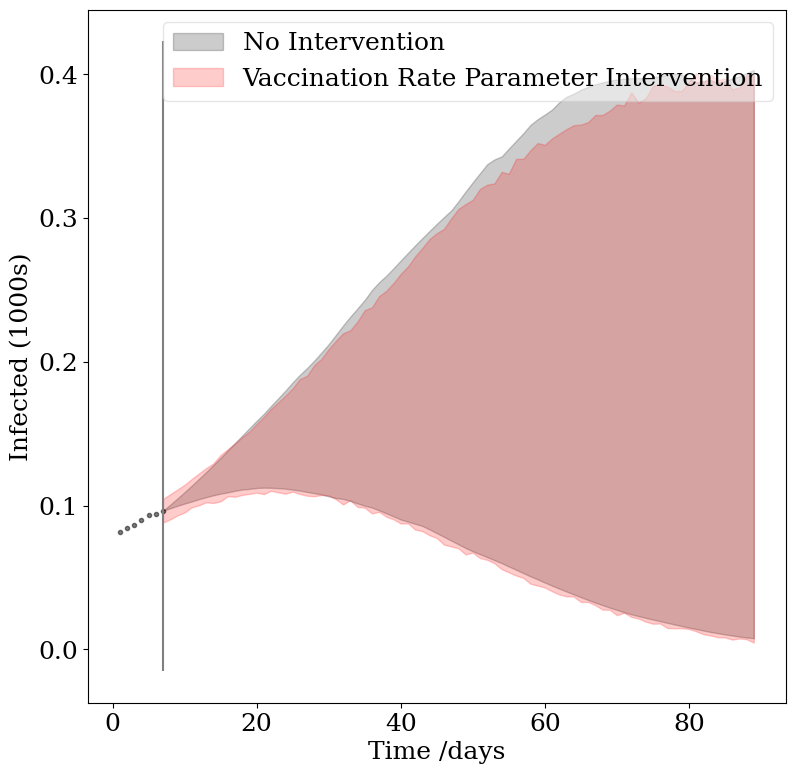

In [31]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, tmin=7, ax=ax, label="No Intervention")
ax = plot_predictive(intervened_prediction, new_tspan, ax=ax, color='red', label="Vaccination Rate Parameter Intervention")
ax = plot_intervention_line(7., ax=ax)


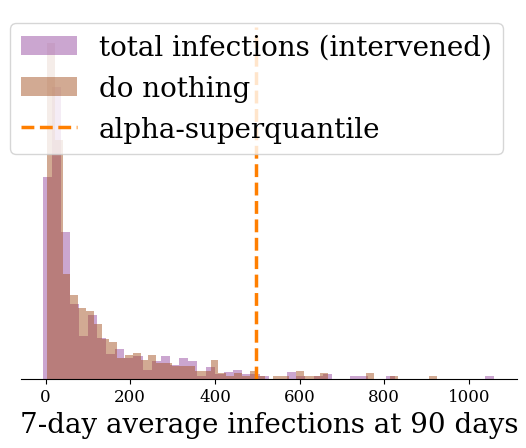

In [32]:
bins_hist = 50
fig1 = plt.figure()
# plt.rc('text')
plt.rc('font', family='serif', size=18.)
cax = plt.gca()
sideaxishist(cax)
cax.hist(qois, color=co[2], bins=bins_hist, histtype='stepfilled', alpha=0.5, label='total infections (intervened)', density=True)
cax.hist(VAX_RISK.qoi(posterior_prediction), color=co[4], bins=bins_hist, histtype='stepfilled', alpha=0.5, label='do nothing', density=True)
miny = min(cax.get_ylim())
maxy = max(cax.get_ylim())
cax.vlines(est_risk, miny, maxy, linestyle='--', linewidth=2.5, label='alpha-superquantile', color=co[1])
cax.set_xlabel('7-day average infections at 90 days', size=20)
cax.legend(loc='upper right', prop={'size': 20})
plt.show()